In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ML - PART I

In [3]:
df = pd.read_csv("movies.csv", encoding='latin-1')

In [4]:
df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df.drop('movieId', axis=1, inplace=True)

In [6]:
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    return int(match.group(1)) if match else None

df['year'] = df['title'].apply(extract_year)
df.head()

,title,genres,year
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,Jumanji (1995),Adventure|Children|Fantasy,1995
2,Grumpier Old Men (1995),Comedy|Romance,1995
3,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,Father of the Bride Part II (1995),Comedy,1995


In [7]:
def clean_title(title):
    """Remove the year of the movie title."""
    return re.sub(r' \(\d{4}\)', '', title)

# Create the column 'title_clean' removing the year of the original tile 
df['title_clean'] = df['title'].apply(clean_title)
df.drop('title', axis=1, inplace=True)
df.head()

,genres,year,title_clean
0,Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
1,Adventure|Children|Fantasy,1995,Jumanji
2,Comedy|Romance,1995,Grumpier Old Men
3,Comedy|Drama|Romance,1995,Waiting to Exhale
4,Comedy,1995,Father of the Bride Part II


In [8]:
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(df['genres'].str.split('|')),
                              columns=mlb.classes_, index=df.index)
df = pd.concat([df, genres_encoded], axis=1)
df.head()

,genres,year,title_clean,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adventure|Children|Fantasy,1995,Jumanji,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Comedy|Romance,1995,Grumpier Old Men,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,Comedy|Drama|Romance,1995,Waiting to Exhale,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Comedy,1995,Father of the Bride Part II,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(2500, 22)

## K-Means

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_genres = genres_encoded  # Select only the encoded genre columns
scaler_genres = StandardScaler()
X_scaled_genres = scaler_genres.fit_transform(X_genres)

In [12]:
df = df.dropna(subset=['year'])

# Concatenate encoded genres and year
X_year_genres = pd.concat([df[mlb.classes_], df['year']], axis=1)

# Scale genres + year
scaler_year_genres = StandardScaler()
X_scaled_genres_year = scaler_year_genres.fit_transform(X_year_genres)
X_year_genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1995
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1995
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1995
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1995
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1995


Elbow Method Plot (genres only):


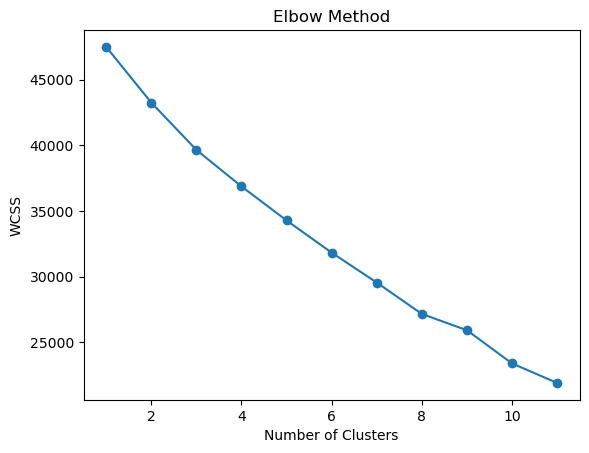


Elbow Method Plot (genres and year):


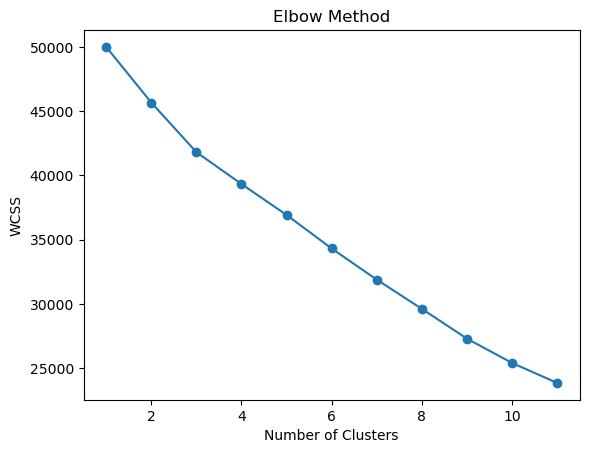

In [13]:
def plot_elbow_method(X_scaled, max_clusters):
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, max_iter = 300, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

print("Elbow Method Plot (genres only):")
plot_elbow_method(X_scaled_genres, 11)  # Test with a range of clusters

print("\nElbow Method Plot (genres and year):")
plot_elbow_method(X_scaled_genres_year, 11) # Test with a range of clusters

In [14]:
# K-means with genres only
kmeans_genres = KMeans(n_clusters=8, random_state=42, n_init=10)
df['cluster_genres'] = kmeans_genres.fit_predict(X_scaled_genres)
print("\nMovies clustered (genres only):")
print(df[['title_clean', 'cluster_genres']].head())


Movies clustered (genres only):
                   title_clean  cluster_genres
0                    Toy Story               6
1                      Jumanji               3
2             Grumpier Old Men               1
3            Waiting to Exhale               1
4  Father of the Bride Part II               1


In [15]:
# K-means with genres + year
kmeans_genres_year = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster_genres_year'] = kmeans_genres_year.fit_predict(X_scaled_genres_year)

print("\nMovies clustered (genres + year):")
print(df[['title_clean', 'year', 'cluster_genres_year']].head())

# Evaluate cluster quality using Silhouette Score
from sklearn.metrics import silhouette_score

score_genres = silhouette_score(X_scaled_genres, df['cluster_genres'])
score_genres_year = silhouette_score(X_scaled_genres_year, df['cluster_genres_year'])

print(f"\nSilhouette Score (genres only): {score_genres:.3f}")
print(f"Silhouette Score (genres + year): {score_genres_year:.3f}")


Movies clustered (genres + year):
                   title_clean  year  cluster_genres_year
0                    Toy Story  1995                    0
1                      Jumanji  1995                    0
2             Grumpier Old Men  1995                    2
3            Waiting to Exhale  1995                    2
4  Father of the Bride Part II  1995                    2

Silhouette Score (genres only): 0.232
Silhouette Score (genres + year): 0.148


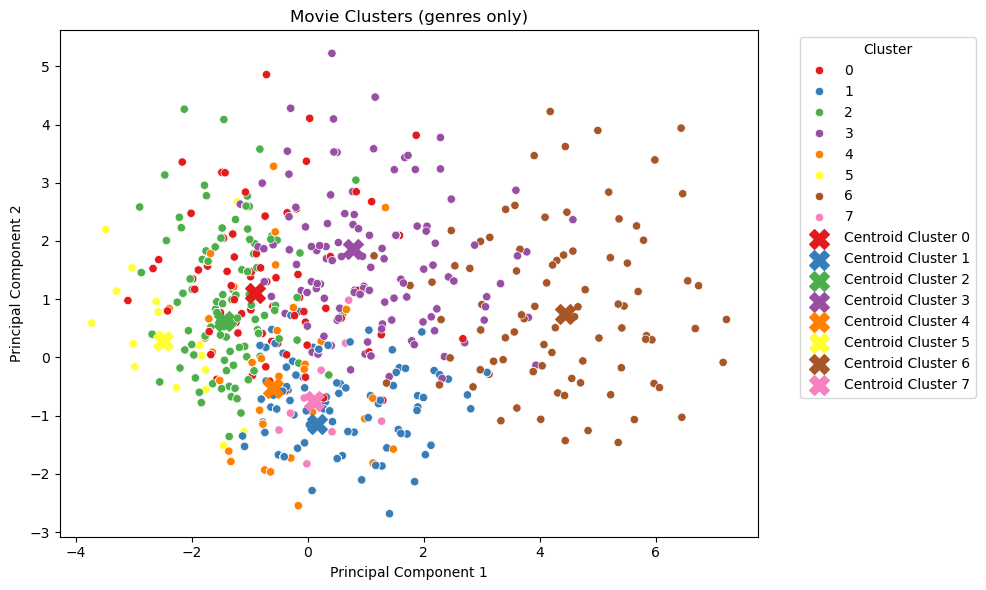

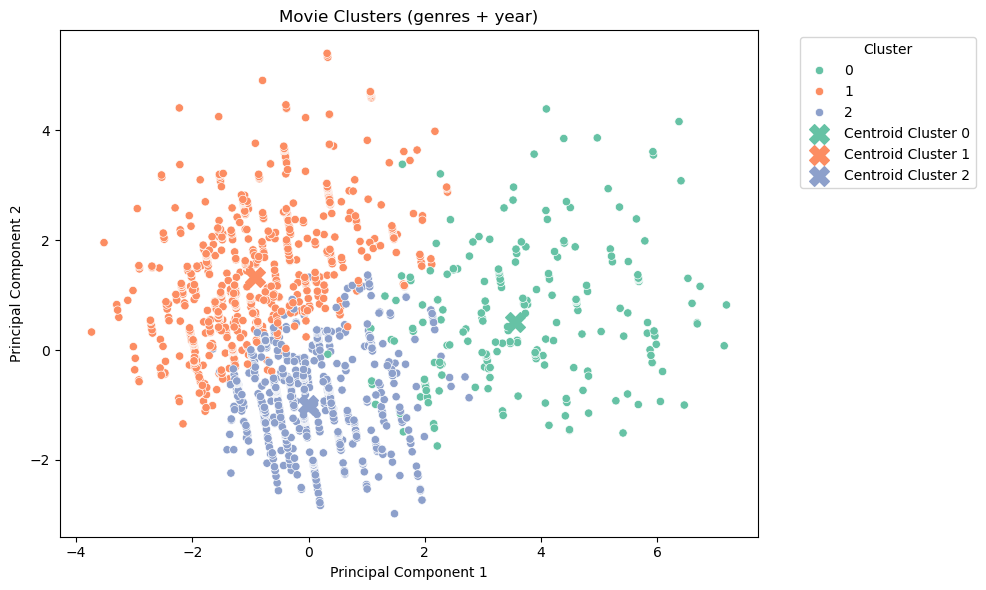

In [16]:
from sklearn.decomposition import PCA
# Reduce to 2D for plotting
pca_genres = PCA(n_components=2)
X_pca_genres = pca_genres.fit_transform(X_scaled_genres)

pca_genres_year = PCA(n_components=2)
X_pca_genres_year = pca_genres_year.fit_transform(X_scaled_genres_year)

# Also transform the KMeans centroids to plot them
centroids_genres = pca_genres.transform(kmeans_genres.cluster_centers_)
centroids_genres_year = pca_genres_year.transform(kmeans_genres_year.cluster_centers_)

# --- Plot for genres only ---
plt.figure(figsize=(10, 6))
unique_clusters_genres = sorted(df['cluster_genres'].unique()) # Ensure consistent order
palette_genres = sns.color_palette('Set1', n_colors=len(unique_clusters_genres))
sns.scatterplot(x=X_pca_genres[:, 0], y=X_pca_genres[:, 1], hue=df['cluster_genres'], palette=palette_genres, legend='full')
for i, cluster_label in enumerate(unique_clusters_genres):
    centroid = centroids_genres[i]
    plt.scatter(centroid[0], centroid[1], s=200, c=[palette_genres[i]], marker='X', label=f'Centroid Cluster {cluster_label}')
plt.title('Movie Clusters (genres only)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()


# --- Plot for genres + year ---
plt.figure(figsize=(10, 6))
unique_clusters_year = sorted(df['cluster_genres_year'].unique()) 
palette_year = sns.color_palette('Set2', n_colors=len(unique_clusters_year))
sns.scatterplot(x=X_pca_genres_year[:, 0], y=X_pca_genres_year[:, 1], hue=df['cluster_genres_year'], palette=palette_year, legend='full')
for i, cluster_label in enumerate(unique_clusters_year):
    centroid = centroids_genres_year[i]
    plt.scatter(centroid[0], centroid[1], s=200, c=[palette_year[i]], marker='X', label=f'Centroid Cluster {cluster_label}')
plt.title('Movie Clusters (genres + year)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## K-Medoids

In [18]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import distance_metric, type_metric
import random
# Convert scaled data to a list of lists, as required by pyclustering
X_list = X_scaled_genres.tolist()

# Randomly select 8 initial medoid indices from the data
initial_medoids = random.sample(range(len(X_list)), 8)
print("Initial medoid indices:", initial_medoids)

Initial medoid indices: [1184, 1520, 1220, 1463, 1757, 1407, 938, 1786]


In [19]:
# Create a K-Medoids model instance
# Uses the data (X_list), initial medoids, specifies data type, and sets a random state
kmedoids_instance = kmedoids(X_list, initial_medoids, data_type='points', random_state=42)

# Run the clustering algorithm
kmedoids_instance.process()

# Get the results: cluster assignments and final medoid indices
clusters = kmedoids_instance.get_clusters()
final_medoids = kmedoids_instance.get_medoids()

# Print the found clusters (list of data indices for each cluster)
print("Found Clusters:", clusters)
# Print the indices of the final medoid for each cluster
print("Final Medoids:", final_medoids)

Found Clusters: [[101, 206, 443, 451, 456, 463, 483, 574, 599, 629, 632, 636, 644, 657, 668, 759, 804, 855, 1046, 1269, 1492, 1515, 1591, 1604, 1709, 1823, 2201, 2256, 2459], [100, 161, 180, 223, 236, 244, 255, 322, 333, 340, 372, 402, 467, 488, 589, 596, 638, 650, 667, 687, 723, 724, 742, 953, 979, 1028, 1093, 1138, 1178, 1192, 1253, 1340, 1341, 1352, 1386, 1475, 1501, 1527, 1539, 1546, 1577, 1586, 1589, 1651, 1756, 1759, 1777, 2330, 2338, 2355, 2449, 2486], [5, 7, 8, 13, 18, 21, 29, 37, 40, 42, 52, 57, 64, 68, 82, 87, 97, 102, 105, 106, 107, 113, 114, 122, 125, 127, 136, 154, 157, 171, 174, 175, 186, 187, 200, 208, 211, 227, 229, 230, 232, 233, 237, 238, 247, 249, 256, 261, 268, 269, 273, 276, 281, 285, 289, 298, 300, 306, 312, 313, 316, 318, 323, 332, 334, 356, 357, 359, 367, 378, 379, 380, 385, 387, 392, 398, 400, 412, 413, 416, 419, 423, 426, 435, 438, 457, 459, 462, 482, 485, 513, 517, 518, 523, 534, 536, 539, 547, 555, 557, 584, 586, 597, 605, 624, 633, 648, 651, 659, 675, 698, 

In [20]:
# Create an array to hold the cluster label for each data point
cluster_labels = np.empty(len(X_list))

# Loop through the clusters and assign the cluster index as a label to each sample
for cluster_idx, cluster in enumerate(clusters):
    for sample_idx in cluster:
        cluster_labels[sample_idx] = cluster_idx

# Add the cluster labels as a new integer column named 'cluster_kmedoids' to the DataFrame df
df['cluster_kmedoids'] = cluster_labels.astype(int)

# Print the first 5 rows, showing the original title and the assigned cluster
print(df[['title_clean', 'cluster_kmedoids']].head())

                   title_clean  cluster_kmedoids
0                    Toy Story                 4
1                      Jumanji                 4
2             Grumpier Old Men                 7
3            Waiting to Exhale                 7
4  Father of the Bride Part II                 7


In [21]:
from sklearn.metrics import silhouette_score

silhouette_kmedoids = silhouette_score(X_scaled_genres, cluster_labels)
print(f"Silhouette Score for K-Medoids (genre): {silhouette_kmedoids:.3f}")

Silhouette Score for K-Medoids (genre): 0.203


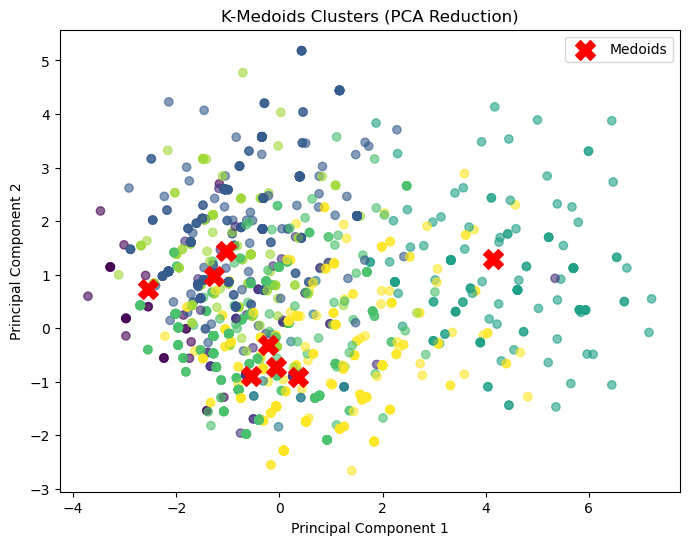

In [22]:
# Perform PCA to reduce data to 2 components for visualization
pca = PCA(n_components=2, random_state=42)
X_pca_kmedoids = pca.fit_transform(X_scaled_genres)

# Create a scatter plot of the PCA-transformed data, colored by cluster labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_kmedoids[:, 0], X_pca_kmedoids[:, 1],
                      c=cluster_labels, cmap='viridis', alpha=0.6)

# Get the PCA coordinates of the final medoids
medoid_points = np.array([X_pca_kmedoids[idx] for idx in final_medoids])

# Plot the final medoids on the scatter plot with a distinct marker and color
plt.scatter(medoid_points[:, 0], medoid_points[:, 1],
            marker='X', c='red', s=200, label='Medoids')

# Add plot title and axis labels
plt.title('K-Medoids Clusters (PCA Reduction)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Hierarchical Clustering

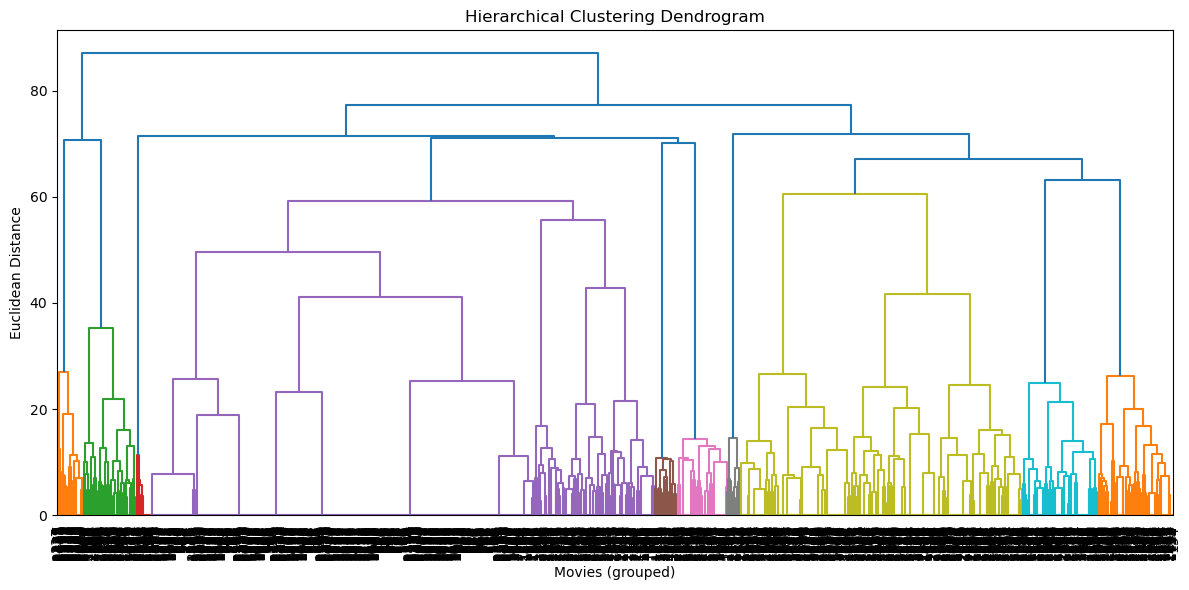

In [24]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

# Create the dendrogram
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(
    sch.linkage(X_scaled_genres, method='ward'),
    leaf_rotation=90.,  # PCA for 2D reduction
    leaf_font_size=10.,  # Font size for the leaf labels
    show_contracted=True  # Show contracted clusters in the dendrogram
)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Movies (grouped)')
plt.ylabel('Euclidean Distance')
plt.tight_layout()
plt.show()

In [25]:
from sklearn.cluster import AgglomerativeClustering

# Define the desired number of clusters
n_clusters = 4

# Create and configure the Agglomerative Clustering model
agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

# Apply the clustering to the data and add results to the DataFrame
df['cluster_agg'] = agg.fit_predict(X_scaled_genres)

# Import Silhouette Score for evaluation
from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score for the clustering
silhouette_agg = silhouette_score(X_scaled_genres, df['cluster_agg'])
# Print the calculated Silhouette Score
print(f"Silhouette Score (Agglomerative Clustering): {silhouette_agg:.3f}")

# Show the first few rows with movie titles and assigned clusters
print(df[['title_clean', 'cluster_agg']].head())

Silhouette Score (Agglomerative Clustering): 0.128
                   title_clean  cluster_agg
0                    Toy Story            1
1                      Jumanji            0
2             Grumpier Old Men            0
3            Waiting to Exhale            0
4  Father of the Bride Part II            0


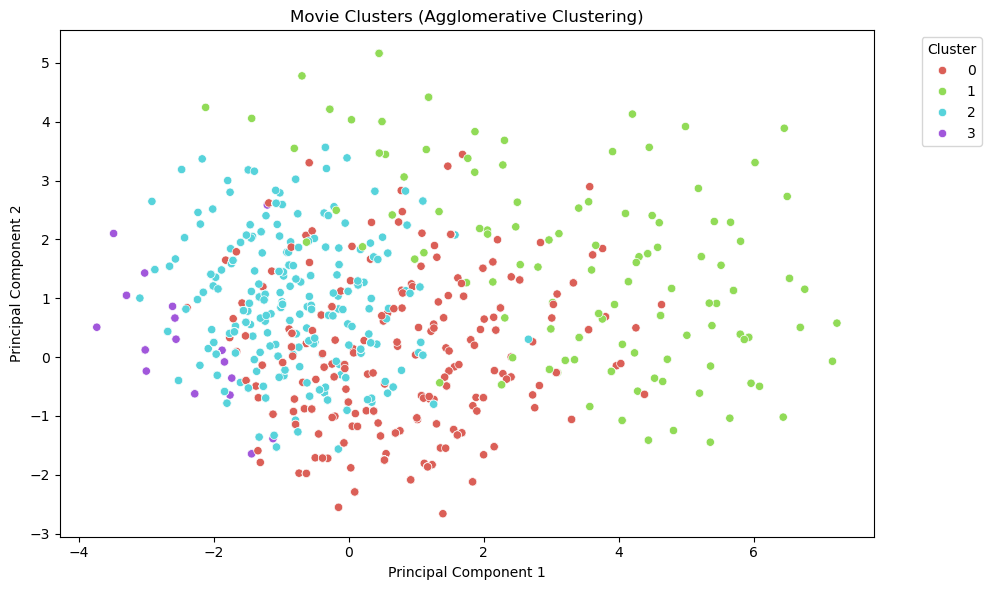

In [26]:
# Perform PCA to reduce the data to 2D for visualization
pca_agg = PCA(n_components=2)
X_pca_agg = pca_agg.fit_transform(X_scaled_genres)

# Get the number of unique clusters and create a color palette for plotting
n_clusters_agg = df['cluster_agg'].nunique()
palette_agg = sns.color_palette("hls", n_colors=n_clusters_agg)

# Create a figure for the scatter plot
plt.figure(figsize=(10, 6))

# Generate a scatter plot of the data points in the 2D PCA space.
sns.scatterplot(
    x=X_pca_agg[:, 0], y=X_pca_agg[:, 1],
    hue=df['cluster_agg'],
    palette=palette_agg,
    legend='full'
)

# Set the title and axis labels for the plot (in English)
plt.title('Movie Clusters (Agglomerative Clustering)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Position the legend outside the plot area
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# ML - PART II

In [28]:
df = pd.read_csv("movies.csv", encoding='latin-1')

In [29]:
df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [30]:
df2 = pd.read_csv("rating.csv")

In [31]:
df2.head()

,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


In [32]:
df3 = pd.read_csv("tags.csv", encoding='latin-1')

In [33]:
df3.head()

,movieId,userId,tag,timestamp
0,3916,12882,sports,1147195545
1,4085,12882,Eddie Murphy,1147195966
2,33660,12882,boxing,1147195514
3,1197,320,must show,1145964801
4,1396,320,must show,1145964810


## Recommender system based on User-Rating (item-item)
If movie X and movie Y were rated similarly by many users (users who rated X well also tended to rate Y well, and those who rated X poorly also tended to rate Y poorly), then if a user likes movie X, it is likely that he or she will also like movie Y

In [35]:
df2["rating"].describe()

count    264505.000000
mean          3.504062
std           0.993534
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [36]:
df2.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
#Create the user-item ratings matrix
user_item_matrix = df2.pivot_table(index='userId', columns='movieId', values='rating')

In [38]:
user_item_matrix_sparse = csr_matrix(user_item_matrix.fillna(0))

In [39]:
#Compute cosine similarity between items
item_similarity = cosine_similarity(user_item_matrix_sparse.T)

item_similarity_df = pd.DataFrame(item_similarity, 
                                   index=user_item_matrix.columns,
                                   columns=user_item_matrix.columns)

In [40]:
#Function to get similar movies
def get_similar_movies(movie_id, top_n=10):
    similar_scores = item_similarity_df[movie_id].sort_values(ascending=False)
    top_similar = similar_scores.iloc[1:top_n+1]  # exclude the movie itself
    return df[df['movieId'].isin(top_similar.index)][['title', 'movieId']].assign(similarity=top_similar.values)

# Example: Movies similar to movieId 1 (Toy Story)
similar_movies = get_similar_movies(1)
print(similar_movies)

                                          title  movieId  similarity
157   Star Wars: Episode IV - A New Hope (1977)      260    0.790953
213                         Forrest Gump (1994)      356    0.784430
276                        Jurassic Park (1993)      480    0.769489
654                   Back to the Future (1985)     1270    0.764521
786            Men in Black (a.k.a. MIB) (1997)     1580    0.764007
1419                         Toy Story 2 (1999)     3114    0.764001
1753                               Shrek (2001)     4306    0.754629
1835                      Monsters, Inc. (2001)     4886    0.753534
2001                        Finding Nemo (2003)     6377    0.747935
2162                    Incredibles, The (2004)     8961    0.742634


## Recommender system based on Genres (item-item)

If two movies have similar content characteristics (in this case, if they share many genres), then a person who liked one of those movies is likely to like the other

In [42]:
from sklearn.preprocessing import MultiLabelBinarizer
#Convert genres to binary format
df['genres_list'] = df['genres'].apply(lambda x: x.split('|'))
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(df['genres_list'])

In [43]:
#Compute cosine similarity matrix based on genres
cosine_sim = cosine_similarity(genre_matrix)

#Function to get top 10 similar movies
def get_top_similar_movies(title, top_n=10):
    if title not in df['title'].values:
        return f"'{title}' is not in the dataset."
    
    idx = df[df['title'] == title].index[0]
    sim_scores = cosine_sim[idx]
    
    sim_df = pd.DataFrame({
        'title': df['title'],
        'similarity': sim_scores
    })
    
    # Exclude the original movie from the results
    sim_df = sim_df[df['title'] != title]
    
    return sim_df.sort_values(by='similarity', ascending=False).head(top_n)

#Example: Movies similar to "Toy Story (1995)"
results = get_top_similar_movies('Toy Story (1995)', top_n=10)
print(results)

                                               title  similarity
1075                                     Antz (1998)    1.000000
2312                          Shrek the Third (2007)    1.000000
1419                              Toy Story 2 (1999)    1.000000
1620  Adventures of Rocky and Bullwinkle, The (2000)    1.000000
1696                Emperor's New Groove, The (2000)    1.000000
1835                           Monsters, Inc. (2001)    1.000000
362                                 Space Jam (1996)    0.912871
2433                              Toy Story 3 (2010)    0.912871
1753                                    Shrek (2001)    0.912871
1767                Atlantis: The Lost Empire (2001)    0.894427


In [44]:
# Display genres of the selected movie + top 10 similar movies for comparisson
def show_genres_for_similar_movies(title, top_n=10):
    similar_movies = get_top_similar_movies(title, top_n=top_n)

    # Include the original movie
    titles_to_show = [title] + similar_movies['title'].tolist()

    genres_df = df[df['title'].isin(titles_to_show)][['title', 'genres']]
    return genres_df.reset_index(drop=True)


genres_comparison = show_genres_for_similar_movies('Toy Story (1995)', top_n=10)
genres_comparison

,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Space Jam (1996),Adventure|Animation|Children|Comedy|Fantasy|Sc...
2,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
3,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
4,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
5,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
6,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
7,Atlantis: The Lost Empire (2001),Adventure|Animation|Children|Fantasy
8,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
9,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy


## Recommender System based on user ratings (User-User)

In [46]:
# Create a user-item rating matrix (users as rows, movies as columns)
user_item_matrix = df2.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

In [47]:
#Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)


In [48]:
#User-based Collaborative Filtering function
def recommend_movies_user_user(target_user_id, top_n_users=5, top_n_movies=5):
    # Get most similar users (excluding the user themself at index 0)
    similar_users = user_similarity_df[target_user_id].sort_values(ascending=False).iloc[1:top_n_users+1]

    # Get the ratings from those similar users
    similar_users_ratings = user_item_matrix.loc[similar_users.index]

    # Compute weighted average scores for each movie, weighted by similarity
    weighted_ratings = similar_users_ratings.T.dot(similar_users) / similar_users.sum()

    # Identify which movies the target user has already rated
    user_seen_movies = user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id] > 0].index

    # Drop already seen movies and keep only top N recommendations
    recommendations = weighted_ratings.drop(user_seen_movies).sort_values(ascending=False).head(top_n_movies)

    print("Movies already seen by user:")
    print(user_seen_movies)

    print("\nTop predicted ratings before filtering:")
    print(weighted_ratings.sort_values(ascending=False).head(10))

    recommended_movies = df[df['movieId'].isin(recommendations.index)]

    # Reorder to match recommendations and assign predicted scores
    recommended_movies = recommended_movies.set_index('movieId').loc[recommendations.index]
    recommended_movies = recommended_movies.assign(predicted_rating=recommendations.values)
    recommended_movies['predicted_rating'] = recommended_movies['predicted_rating'].round(2)

    return recommended_movies

In [49]:
recommendations = recommend_movies_user_user(target_user_id=12882, top_n_users=5, top_n_movies=5)
recommendations

Movies already seen by user:
Index([    1,    32,    47,    50,   110,   150,   158,   165,   260,   296,
       ...
        8958,  8961,  8970, 33166, 33660, 33794, 40815, 40819, 41566, 44199],
      dtype='int64', name='movieId', length=106)

Top predicted ratings before filtering:
movieId
7153    4.899390
4993    4.798780
5952    4.702432
260     4.598001
2571    4.505913
1196    4.401042
1210    4.397283
110     4.396557
2762    4.297097
6539    4.293307
dtype: float64


,title,genres,genres_list,predicted_rating
movieId,,,,
33493,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi,"[Action, Adventure, Sci-Fi]",4.09
3996,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",Action|Drama|Romance,"[Action, Drama, Romance]",3.82
541,Blade Runner (1982),Action|Sci-Fi|Thriller,"[Action, Sci-Fi, Thriller]",3.63
6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,"[Action, Crime, Thriller]",3.40
1682,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi,"[Comedy, Drama, Sci-Fi]",3.09


In [50]:
# Function to get similar users (for inspection/debugging)
def get_similar_users(target_user_id, top_n_users=5):
    similar_users = user_similarity_df[target_user_id].sort_values(ascending=False).iloc[1:top_n_users+1]
    return similar_users
similar_users = get_similar_users(12882)
print(similar_users)

userId
113673    0.472474
107991    0.464843
103667    0.464699
12569     0.462378
98644     0.445017
Name: 12882, dtype: float64


In [51]:
#Function to show ratings from similar users (for inspection)
def show_similar_users_ratings(target_user_id, top_n_users=5):
    similar_users = get_similar_users(target_user_id, top_n_users)
    ratings_matrix = user_item_matrix.loc[similar_users.index]
    return ratings_matrix
ratings_of_similars = show_similar_users_ratings(12882)
ratings_of_similars.head()

movieId,1,2,3,4,5,6,7,9,10,11,...,106487,106489,106782,106920,109374,109487,111362,111759,112556,112852
userId,,,,,,,,,,,,,,,,,,,,,
113673,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103667,4.5,3.5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12569,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98644,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
